<ipython-input-2-2765cf8fb13a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df["SMA_5"] = daily_df["daily_cases"].rolling(window=5).mean()
<ipython-input-2-2765cf8fb13a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df["EMA_5"] = daily_df["daily_cases"].ewm(span=5, adjust=False).mean()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/u

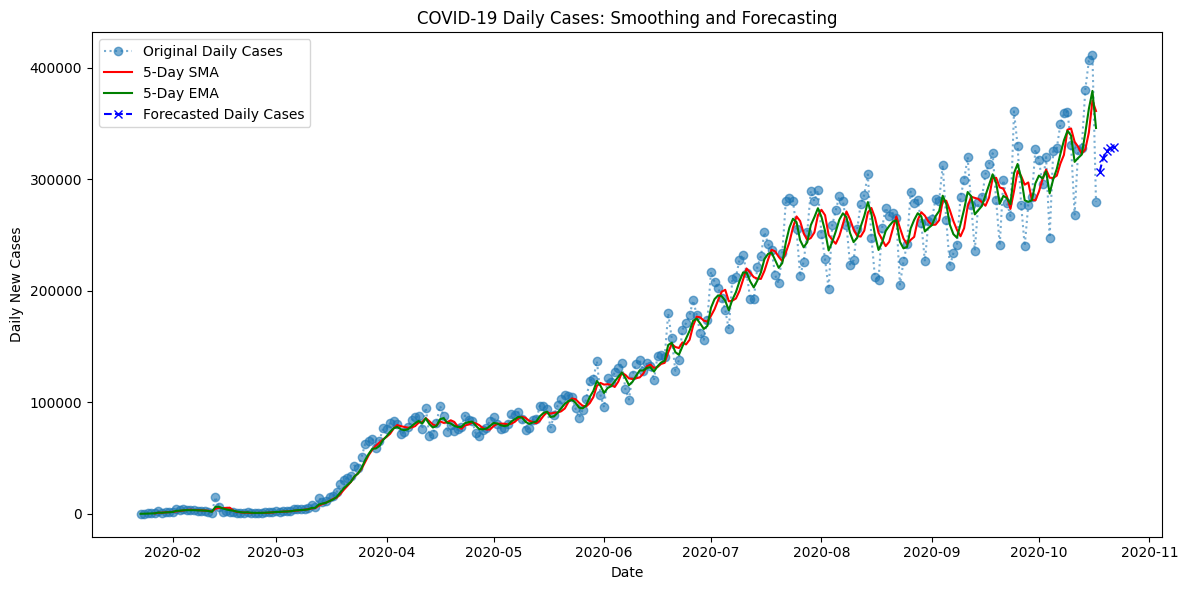

OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = "/time-series-19-covid-combined.csv"
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date' to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# Aggregate global daily confirmed cases
daily_df = df.groupby(df.index).sum()

# Create daily new cases
daily_df["daily_cases"] = daily_df["Confirmed"].diff().dropna()

# Drop any missing values
daily_df = daily_df.dropna(subset=["daily_cases"])

# Add SMA and EMA (5-day window)
daily_df["SMA_5"] = daily_df["daily_cases"].rolling(window=5).mean()
daily_df["EMA_5"] = daily_df["daily_cases"].ewm(span=5, adjust=False).mean()

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(daily_df["daily_cases"], order=(1, 1, 1))
model_fit = model.fit()

# Forecast next 5 days
forecast = model_fit.forecast(steps=5)
future_dates = pd.date_range(start=daily_df.index.max() + pd.Timedelta(days=1), periods=5)

# Create forecast DataFrame
forecast_df = pd.DataFrame({"Date": future_dates, "Forecasted_daily_cases": forecast})
forecast_df.set_index("Date", inplace=True)

# Combine actual and forecasted data
combined_df = pd.concat([daily_df, forecast_df], axis=0)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_df.index, daily_df["daily_cases"], label="Original Daily Cases", linestyle='dotted', marker='o', alpha=0.6)
plt.plot(daily_df.index, daily_df["SMA_5"], label="5-Day SMA", color='red')
plt.plot(daily_df.index, daily_df["EMA_5"], label="5-Day EMA", color='green')
plt.plot(forecast_df.index, forecast_df["Forecasted_daily_cases"], label="Forecasted Daily Cases", color="blue", marker="x", linestyle="--")
plt.legend()
plt.title("COVID-19 Daily Cases: Smoothing and Forecasting")
plt.xlabel("Date")
plt.ylabel("Daily New Cases")
plt.tight_layout()
plt.show()

# Save smoothed and forecasted data
output_path = "/mnt/data/covid_smoothed_forecast.csv"
combined_df.to_csv(output_path)

print(f"✅ Smoothed and forecasted data saved to: {output_path}")
